# Load data

References:

- [xG model post](https://www.frontiersin.org/journals/sports-and-active-living/articles/10.3389/fspor.2024.1348983/full)
- [statsbomb data](https://github.com/statsbomb/open-data/tree/master/data)
- [xG model paper](https://www.sciencedirect.com/science/article/pii/S2773186323000282)
- [Model Calibration post](https://www.giskard.ai/glossary/model-calibration)

Load the data from the parquet file and select the columns we need.

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
import inspect
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import shap


In [2]:
pd.set_option("display.max_columns", None)
data_dir = f"{os.path.abspath(os.path.join(os.getcwd(), '..'))}/data/processed_data/"

In [3]:
df = pd.read_parquet(f"{data_dir}/complete_data.parquet")

## Benchmark Accuracy from StatsBomb xG

In [4]:
threshold = 0.5
predictions = (df['shot_statsbomb_xg'] > threshold).astype(int)

# Calculate accuracy
accuracy = (predictions == df['target']).mean()
print(f"Accuracy of StatsBomb xG predictions: {accuracy:.2f}")

Accuracy of StatsBomb xG predictions: 0.90


# Embedding Layer for Categorical Data

We need to encode the categorical data so our network can learn.

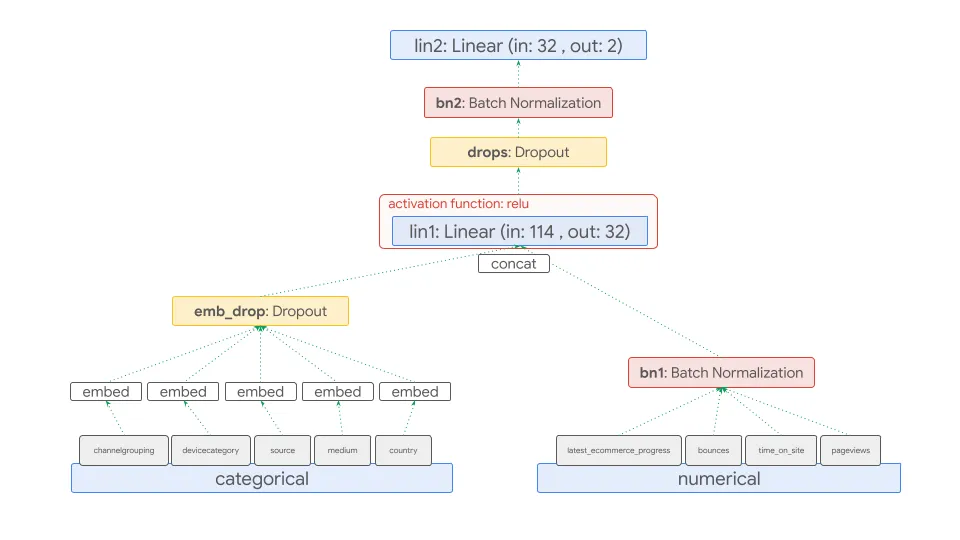

After trialing with adding the player_id to the embedding layer, I found that it was not beneficial to the model. So will be removod to simply, but code is kept for future reference.

In [5]:
categorical_columns = [
    # 'player_id',
    'play_pattern',
    'position_simplified',
    'shot_body_part',
    'shot_technique',
    'shot_type'
    ]

In [6]:
df_inputs = df[['play_pattern', 'position_simplified', 'shot_body_part',
    'shot_technique', 'shot_type','shot_aerial_won', 'under_pressure',
    'shot_first_time', 'shot_one_on_one', 'distance_to_goal','shot_angle',
    'opponents_within_radius', 'gk_distance_to_goal', 'players_in_shot_triangle', 'target',
    ]]

In [7]:
# # Count occurrences of each player_id
# player_counts = df_inputs['player_id'].value_counts()
# # Assign a unique ID to player_ids that appear less than 3 times
# unique_id = -1  # or any other unique identifier you prefer
# df_inputs.loc[:, 'player_id'] = df_inputs.loc[:, 'player_id'].apply(lambda x: unique_id if player_counts[x] < 3 else x)

In [8]:
labelencoder = defaultdict(LabelEncoder)

In [9]:
df_inputs.loc[:,categorical_columns] = df_inputs.loc[:,categorical_columns].apply(lambda x: labelencoder[x.name].fit_transform(x))
df_inputs[categorical_columns] = df_inputs[categorical_columns].astype('category')

/var/folders/63/yhtvbsns19d1qd7844r5xq880000gn/T/ipykernel_46540/126255024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs[categorical_columns] = df_inputs[categorical_columns].astype('category')


In [10]:
# # Example of transforming a player_id that is not in the labelencoder to unknown token
# player_id = 1000.0
# if player_id not in labelencoder['player_id'].classes_:
#     print(labelencoder['player_id'].transform([-1]))


Using an approach from the fastai library, we can create embedding layers for the categorical columns.

In [11]:
emb_c = {n: len(col.cat.categories) for n, col in df_inputs.items() if col.dtype == 'category'}

In [12]:
emb_cols = emb_c.keys() # names of columns chosen for embedding
emb_szs = [(c, min(50, (c+1)//2)) for _,c in emb_c.items()] #embedding sizes for the chosen columns

In [13]:
embedding_sizes = nn.ModuleList([nn.Embedding(categories, size) for categories,size in emb_szs])

In [14]:
# Save the labelencoder to a file so we can recover the encoded data
pickle.dump(labelencoder, open('label.pkl', 'wb'))
# Save the embedding sizes to a file so we can recover the embedding sizes
pickle.dump(embedding_sizes, open('emb.pkl', 'wb'))


## Split the data into training and validation sets

In [15]:
X_train, X_val, y_train, y_val = train_test_split(df_inputs.iloc[:, :-1], df_inputs.iloc[:, -1], test_size=0.1, random_state=42, shuffle=True)
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

## Standardise the numerical data

For optimal performance, we should standardise the numerical data. 

We can save the scaler to a file so we can use it to transform the data later.

In [16]:
num_columns = ['distance_to_goal','shot_angle','opponents_within_radius','gk_distance_to_goal','players_in_shot_triangle']
scaler = StandardScaler()
X_train.loc[:, num_columns] = scaler.fit_transform(X_train.loc[:, num_columns])
X_val.loc[:, num_columns] = scaler.transform(X_val.loc[:, num_columns])
pickle.dump(scaler, open('std_scaler.pkl', 'wb'))

## Create a dataloader

In [99]:
class ShotsDataset(Dataset):
    def __init__(self, X, Y, emb_cols):
        X = X.copy()
        self.X1 = X.loc[:, emb_cols].copy().values.astype(np.int64) #categorical columns
        self.X2 = X.drop(columns=emb_cols).copy().values.astype(np.float32) #numerical columns
        self.y = Y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]


In [100]:
#creating train and valid datasets
train_ds = ShotsDataset(X_train, y_train, emb_cols)
valid_ds = ShotsDataset(X_val, y_val, emb_cols)

## Define the model

In [75]:
class Block(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.1):
        super().__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):
        # Residual connection
        x = x + self.dropout(self.relu(self.fc(self.bn(x))))
        return x


class Model(nn.Module):

    def __init__(
        self,
        embedding_sizes: list[tuple[int, int]],
        n_numerical: int,
        hyperparameters: dict | None = None,
        hidden_size: int | None = 200,
        dropout_rate: float | None = 0.1,
        num_blocks: int | None = 4,
        return_loss: bool = True,
    ):
        super().__init__()

        # Default hyperparameters
        default_hyperparameters = {
            "hidden_size": hidden_size,
            "dropout_rate": dropout_rate,
            "num_blocks": num_blocks,
            "block_config": None
        }


        # Update defaults with any provided hyperparameters
        if hyperparameters:
            default_hyperparameters.update(hyperparameters)

        # Assign hyperparameters
        self.hidden_size = default_hyperparameters["hidden_size"]
        self.dropout_rate = default_hyperparameters["dropout_rate"]
        self.num_blocks = default_hyperparameters["num_blocks"]
        self.block_config = default_hyperparameters["block_config"]
        self.return_loss = return_loss

        # Validate hyperparameters
        assert self.hidden_size > 0, "hidden_size must be positive"
        assert 0 <= self.dropout_rate <= 1, "dropout_rate must be between 0 and 1"
        assert self.num_blocks > 0, "num_blocks must be positive"

        self.criterion = nn.BCEWithLogitsLoss()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories, size in embedding_sizes])
        self.n_emb = sum(e.embedding_dim for e in self.embeddings)  # length of all embeddings combined
        self.emb_drop = nn.Dropout(self.dropout_rate)
        self.n_numerical = n_numerical


        # Inputs and combine embeddings and numerical data
        self.bn1 = nn.BatchNorm1d(self.n_numerical)
        self.fc1 = nn.Linear(self.n_emb + self.n_numerical, self.hidden_size)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(self.dropout_rate)

        if self.block_config:
            self.hidden_layers = nn.ModuleList(
                [Block(hs_in, hs_out, dropout_rate=dropout_rate) for hs_in, hs_out, dropout_rate in self.block_config]
            )
        else:
            self.hidden_layers = nn.ModuleList(
                [Block(self.hidden_size, self.hidden_size, dropout_rate=self.dropout_rate) for _ in range(self.num_blocks)]
            )

        # Output layer
        self.bn_output = nn.BatchNorm1d(self.hidden_size)
        self.fc_output = nn.Linear(self.hidden_size, 1)

        # init all weights
        self.apply(self._init_weights)

        # report number of parameters
        print(f"number of parameters: {sum(p.numel() for p in self.parameters()):,}")

    def forward(self, x_cat, x_cont, targets=None):
        # Embed the categorical data and concatenate
        x = [e(x_cat[:, i]) for i, e in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = self.emb_drop(x)

        # Join the embeddings and the numerical data
        x2 = self.bn1(x_cont)
        x = torch.cat([x, x2], 1)

        # First layer
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.drop1(x)

        for block in self.hidden_layers:
            x = block(x)

        # Output layer
        x = self.bn_output(x)
        logits = self.fc_output(x)

        if self.return_loss:
            loss = None
            if targets is not None:
                # Use BCEWithLogitsLoss for binary classification
                loss = self.criterion(logits.view(-1), targets.float().view(-1))
            return logits, loss
        else:
            return logits


    def _init_weights(self, module):
        """
        Xavier uniform initialization for the linear and embedding layers.
        Generally a good starting point for most models, especially with ReLU activation functions.

        Other Options:

        Kaiming (He) Initialization: This is often recommended for networks with ReLU or variants like Leaky ReLU.
         It helps in maintaining the variance of activations throughout the layers.

        Uniform vs. Normal Distribution: You can choose between uniform and normal distributions for initializing weights.
        Xavier and Kaiming initializations can be applied using either distribution.

        Bias Initialization: Initializing biases to zero is common, but sometimes
        small positive values can help, especially in ReLU networks, to ensure that all neurons are active initially.


        """
        if isinstance(module, nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
            # torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                # torch.nn.init.zeros_(module.bias)
                torch.nn.init.constant_(module.bias, 0.01)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.xavier_uniform_(module.weight)

    def configure_optimizers(
        self,
        weight_decay: float = 0.01,
        learning_rate: float = 3e-4,
        betas: tuple = (0.9, 0.95),
        device_type: str = "cpu",
        min_lr: float = 3e-4,
        warmup_iters: int = 1000,
        lr_decay_iters: int = 10000,
    ):
        """
        Configure the optimizer for the model.
        We use the AdamW optimizer with weight decay.

        The difference between Adam and AdamW is that Adam uses L2 regularization,
        while AdamW uses weight decay directly on the parameters duing updates
        Generally AdamW is preferred as it is more flexible and allows for more control over the learning rate.
        AdamW also helps with generalization and reducing overfitting.
        """
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.betas = betas
        self.min_lr = min_lr
        self.warmup_iters = warmup_iters
        self.lr_decay_iters = lr_decay_iters

        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {"params": decay_params, "weight_decay": weight_decay},
            {"params": nodecay_params, "weight_decay": 0.0},
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = "fused" in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == "cuda"
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    @classmethod
    def from_pretrained(cls, embedding_sizes: list[tuple[int, int]], n_numerical: int, pretrained_model_path: str):
        model = cls(embedding_sizes, n_numerical)
        model.load_state_dict(torch.load(pretrained_model_path))
        return model


In [76]:
def get_lr(it, max_lr, min_lr, warmup_iters, lr_decay_iters):
    """
    Calculate the learning rate for a given iteration using a cosine decay schedule with warmup.

    Parameters:
    - it: Current iteration.
    - max_lr: Maximum learning rate.
    - min_lr: Minimum learning rate.
    - warmup_iters: Number of iterations for linear warmup.
    - lr_decay_iters: Number of iterations over which to decay the learning rate.

    Returns:
    - Learning rate for the current iteration.
    """
    # 1) Linear warmup for warmup_iters steps
    if it < warmup_iters:
        return max_lr * (it + 1) / (warmup_iters + 1)
    # 2) If it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) In between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))  # coeff ranges 0..1
    return min_lr + coeff * (max_lr - min_lr)

In [77]:
def train_model(model, train_dl, step: int, optimizer):
    """Trains the model for one epoch. Returns the average loss for the epoch."""
    model.train()
    total = 0
    sum_loss = 0
    for x1, x2, y in train_dl:
        step += 1
        batch = y.shape[0]
        if device == "cuda":
            with torch.autocast(device_type=device, dtype=torch.bfloat16):
                logits, loss = model(x1, x2, y)
        else:
            logits, loss = model(x1, x2, y)
        loss.backward()

        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Determine the learning rate for this step
        lr = get_lr(step, model.learning_rate, model.min_lr, model.warmup_iters, model.lr_decay_iters)
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        optimizer.step()
        optimizer.zero_grad()

        if device == "cuda":
            torch.cuda.synchronize()  # This will wait for all scheduled work to finish

        total += batch
        sum_loss += batch*(loss.item())

    return sum_loss/total, step

In [78]:
def val_loss(model, valid_dl):
    model.eval()
    with torch.no_grad():
        total = 0
        sum_loss = 0
        correct = 0
        for x1, x2, y in valid_dl:
            current_batch_size = y.shape[0]
            if device == "cuda":
                with torch.autocast(device_type=device, dtype=torch.bfloat16):
                    logits, loss = model(x1, x2, y)
            else:
                logits, loss = model(x1, x2, y)
            sum_loss += current_batch_size*(loss.item())
            total += current_batch_size

            # Apply sigmoid to logits to get probabilities
            probs = torch.sigmoid(logits)
            # Use 0.5 as the threshold to determine the predicted class
            pred = (probs > 0.5).float()
            correct += (pred.view(-1) == y.view(-1)).float().sum().item()

    return sum_loss/total, correct/total

In [79]:
def train_loop(model, epochs, optimizer, save_model: bool = False):
    step = 0
    best_accuracy = 0
    no_improvement_epochs = 0
    patience = 15  # Number of epochs to wait for improvement

    for epoch in range(epochs):
        loss, step = train_model(model, train_dl, step, optimizer)
        # print(f"Epoch {epoch} Step {step} training loss: {loss:.3f}")
        loss, accuracy = val_loss(model, valid_dl)
        # print(f"Epoch {epoch} Step {step} valid loss {loss:.3f} and accuracy {accuracy:.3f}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            if save_model:
                torch.save(model.state_dict(), 'best_model.pth')
            no_improvement_epochs = 0  # Reset counter if improvement
        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= patience:
            print("Early stopping due to no improvement in validation accuracy.")
            break
    print(f"best accuracy: {best_accuracy:.3f}")
    return best_accuracy


## Hyperparameter tuning

In [24]:
from itertools import product

In [25]:
# Define the hyperparameter grid
param_grid = {
    'batch_size': [256],
    'epochs': [100],
    'hidden_size': [200, 400],
    'dropout_rate': [0.1],
    'num_blocks': [5, 8],
    'learning_rate': [3e-2],
}

In [26]:
# Function to train and evaluate the model
def evaluate_model(hidden_size, dropout_rate, num_blocks, learning_rate, min_lr, warmup_iters, lr_decay_iters):
    # Initialize the model with the current hyperparameters
    model = Model(
        emb_szs,
        X_train.shape[1] - len(emb_cols),
        hyperparameters={
            'hidden_size': hidden_size,
            'dropout_rate': dropout_rate,
            'num_blocks': num_blocks
        }
    )
    optimizer = model.configure_optimizers(
        learning_rate=learning_rate,
        min_lr=min_lr,
        warmup_iters=warmup_iters,
        lr_decay_iters=lr_decay_iters
        )

    # Train the model
    best_accuracy = train_loop(model, epochs, optimizer, save_model=False)

    return best_accuracy

In [154]:
# Iterate over all combinations of hyperparameters
best_accuracy = 0
best_params = None
epochs = 100

for batch_size, epochs, hidden_size, dropout_rate, num_blocks, learning_rate in product(*param_grid.values()):
    print(f"Evaluating: hidden_size={hidden_size}, dropout_rate={dropout_rate}, num_blocks={num_blocks}, learning_rate={learning_rate}")

    total_steps = batch_size * epochs
    warmup_iters = total_steps * 0.1
    lr_decay_iters = total_steps * 0.9
    min_lr = learning_rate * 0.1

    accuracy = evaluate_model(hidden_size, dropout_rate, num_blocks, learning_rate, min_lr, warmup_iters, lr_decay_iters)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {
            'hidden_size': hidden_size,
            'dropout_rate': dropout_rate,
            'num_blocks': num_blocks,
            'learning_rate': learning_rate
        }

print(f"Best accuracy: {best_accuracy:.3f} with parameters: {best_params}")

Evaluating: hidden_size=200, dropout_rate=0.1, num_blocks=5, learning_rate=0.03
number of parameters: 385,416
num decayed parameter tensors: 13, with 381,797 parameters
num non-decayed parameter tensors: 21, with 3,619 parameters
using fused AdamW: False
Early stopping due to no improvement in validation accuracy.
best accuracy: 0.906
Evaluating: hidden_size=200, dropout_rate=0.1, num_blocks=8, learning_rate=0.03
number of parameters: 507,216
num decayed parameter tensors: 16, with 501,797 parameters
num non-decayed parameter tensors: 30, with 5,419 parameters
using fused AdamW: False
Early stopping due to no improvement in validation accuracy.
best accuracy: 0.905
Evaluating: hidden_size=400, dropout_rate=0.1, num_blocks=5, learning_rate=0.03
number of parameters: 1,004,016
num decayed parameter tensors: 13, with 996,797 parameters
num non-decayed parameter tensors: 21, with 7,219 parameters
using fused AdamW: False
Early stopping due to no improvement in validation accuracy.
best acc

Final parameters (optimised for accuracy with minimal parameters):

In [101]:
batch_size = 256 # 128, 64
epochs = 100
hidden_size=200
dropout_rate=0.1
num_blocks=2
learning_rate=0.03
min_lr = learning_rate * 0.1
total_steps = batch_size * epochs
warmup_iters = total_steps * 0.1
lr_decay_iters = total_steps * 0.9
weight_decay = 0.01
betas = (0.9, 0.95)

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model(emb_szs, X_train.shape[1] - len(emb_cols), hyperparameters={
    'hidden_size': hidden_size,
    'dropout_rate': dropout_rate,
    'num_blocks': num_blocks
})
optimizer = model.configure_optimizers(weight_decay=weight_decay, learning_rate=learning_rate, betas=betas, device_type=device, min_lr=min_lr, warmup_iters=warmup_iters, lr_decay_iters=lr_decay_iters)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

number of parameters: 86,916
num decayed parameter tensors: 9, with 85,097 parameters
num non-decayed parameter tensors: 12, with 1,819 parameters
using fused AdamW: False


In [103]:
autocast = True if device.type == "cuda" else False

# compile the model
if compile and device == "cuda":
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model)  # requires PyTorch 2.0

# Set the data type
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")
else:
    torch.set_float32_matmul_precision("highest")

In [104]:
train_loop(model, epochs, optimizer, save_model=True)

Early stopping due to no improvement in validation accuracy.
best accuracy: 0.908


0.9078234975636167

## SHAP Analysis

Currently SHAP analysis is not working as expected due to the embedding layer. Using a slightly hacky approach with KernelExplainer to get around this.

In [136]:
x1, x2, y = next(iter(train_dl))
print(x1)

tensor([[0, 3, 0, 4, 2],
        [2, 3, 3, 4, 2],
        [8, 3, 3, 2, 2],
        ...,
        [8, 3, 3, 4, 2],
        [3, 3, 1, 4, 2],
        [4, 3, 3, 4, 2]])


In [167]:
model.eval()
def f(X):
        X1 = torch.tensor(X[:, :5], dtype=torch.long)
        X2 = torch.tensor(X[:, 5:], dtype=torch.float32)
        logits, _ = model(X1, X2)
        return logits.detach().numpy()

In [169]:
explainer = shap.KernelExplainer(f, X_train.iloc[:100])

In [170]:
shaps = explainer.shap_values(X_train.iloc[:100], nsamples=500)

  0%|          | 0/100 [00:00<?, ?it/s]

In [210]:
# Visualize the SHAP values for the first instance
shap.initjs()
shap_plot = shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shaps[0].squeeze(), 
    features=X_val.iloc[0].values, 
    feature_names=X_val.columns.tolist()
    )

In [211]:
# Save the plot as an image file
shap.save_html("shap_force_plot.html", shap_plot)

In [212]:
shap.summary_plot(
    shap_values=shaps.squeeze(), 
    features=X_val[:100].to_numpy(), 
    feature_names=X_val.columns.tolist(),
    show=False  # Prevents the plot from displaying immediately
)

plt.savefig("shap_summary_plot.png", bbox_inches='tight')  # Save the plot as a PNG file
plt.close()  # Close the plot to free up memory

## Experiment on 2004/2005 Champions League Final (Liverpool vs AC Milan)

Final Score: Liverpool 3-3 AC Milan

Get the game data

In [222]:
df_05_final = df[(df['competition_name'] == 'Champions League') & (df['season_name'] == '2004/2005')]

Baseline xG

In [227]:
ac_goals = df_05_final[df_05_final['possession_team'] == 'AC Milan']['shot_statsbomb_xg'].sum()
liverpool_goals = df_05_final[df_05_final['possession_team'] == 'Liverpool']['shot_statsbomb_xg'].sum()
print(f"AC Milan: {ac_goals:.2f} xG, Liverpool: {liverpool_goals:.2f} xG")

AC Milan: 6.29 xG, Liverpool: 4.93 xG


Format the data

In [228]:
df_05_final_inputs = df_05_final[['play_pattern', 'position_simplified', 'shot_body_part',
    'shot_technique', 'shot_type','shot_aerial_won', 'under_pressure',
    'shot_first_time', 'shot_one_on_one', 'distance_to_goal','shot_angle',
    'opponents_within_radius', 'gk_distance_to_goal', 'players_in_shot_triangle', 'target',
    ]]

In [229]:
df_05_final_inputs.loc[:,categorical_columns] = df_05_final_inputs.loc[:,categorical_columns].apply(lambda x: labelencoder[x.name].fit_transform(x))
df_05_final_inputs.loc[:, num_columns] = scaler.transform(df_05_final_inputs.loc[:, num_columns])

In [244]:
X1, X2 = df_05_final_inputs.iloc[:, :5], df_05_final_inputs.iloc[:, 5:-1]
X1 = torch.tensor(X1.values.copy().astype(np.int64))
X2 = torch.tensor(X2.values.copy().astype(np.float32))

In [245]:
print(X1.shape)
print(X2.shape)

torch.Size([49, 5])
torch.Size([49, 9])


In [252]:
model.eval()
with torch.no_grad():
    logits, _ = model(X1, X2)
xG = torch.sigmoid(logits)
print(xG.sum())

tensor(4.1540)


In [255]:
xG_array = xG.detach().numpy()

In [258]:
df_05_final['xG'] = xG_array

/var/folders/63/yhtvbsns19d1qd7844r5xq880000gn/T/ipykernel_46540/4085940308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_05_final['xG'] = xG_array


Comparison of xG and actual goals (excluding penalties). Generally my model is more pessimistic than the xG model and real life.


In [263]:
df_05_final[['shot_statsbomb_xg', 'xG', 'shot_outcome']].iloc[:-8]

,shot_statsbomb_xg,xG,shot_outcome
34304,0.064727,0.093620,Goal
34305,0.031492,0.092811,Blocked
34306,0.034621,0.035045,Saved
34307,0.006152,0.005127,Blocked
34308,0.045944,0.049872,Blocked
34309,0.094541,0.095650,Blocked
34310,0.032811,0.017222,Off T
34311,0.046268,0.082777,Off T
34312,0.037582,0.003086,Off T
34313,0.079088,0.038098,Off T


## Visualise the model


In [32]:
from torchviz import make_dot

In [33]:
sample_input_cat = next(iter(train_dl))[0][0]
sample_input_cont = next(iter(train_dl))[1][0]
# Forward pass to get the output
output, _ = model(sample_input_cat.view(1, -1), sample_input_cont.view(1, -1))

In [34]:
# Visualize the model
make_dot(output, params=dict(model.named_parameters())).render("model_graph", format="png")

'model_graph.png'

# Model Callibration

Model callibration is the process of adjusting the output of a model to better match the true probabilities. This is key for utilising an xG model so we can understand the probability of a goal being scored from a given shot. For example a shot with a 0.2 xG should have a 20% chance of being scored, with a 0.8 xG having an 80% chance of being scored. 

Generally when MLP are trained the outputs are not calibrated to the true probabilities. This is where Platt Scaling comes in.

## Platt Scaling

Platt Scaling is typically used for calibrating models for binary classification. It involves training a logistic regression model on the output from your original model using a separate calibration dataset.

The Scikit-learn library includes techniques for improving classifier accuracy through probability calibration.

Platt Scaling (Logistic Regression) method: Fitting a logistic regression model to the classifier’s output probabilities is accomplished by this method. A calibrated probability mapping function from the original probabilities is established by using maximum likelihood estimation. With the assistance of logistic regression, Scikit-learn’s CalibratedClassifierCV class facilitates probability calibration.

In [106]:
def plot_uncalibrated_model(model, validation_loader, device):
    model.eval()
    logits_list = []
    labels_list = []

    # Collect logits and labels from the validation set
    with torch.no_grad():
        for x1, x2, labels in validation_loader:
            x1, x2, labels = x1.to(device), x2.to(device), labels.to(device)
            logits, _ = model(x1, x2)
            logits_list.append(logits.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    logits = np.concatenate(logits_list)
    labels = np.concatenate(labels_list)

    # Convert logits to probabilities using sigmoid
    probs = torch.sigmoid(torch.tensor(logits)).numpy()

    # Calculate the calibration curve
    prob_true, prob_pred = calibration_curve(labels, probs, n_bins=10)

    # Plot the calibration curve
    plt.figure(figsize=(10, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Uncalibrated Model')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve (Reliability Diagram)')
    plt.legend()
    plt.show()

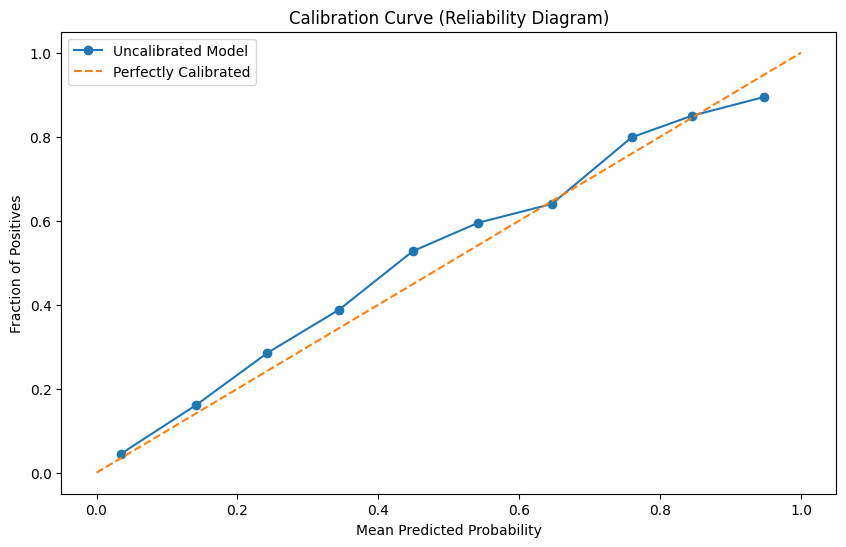

In [107]:
# Call the function to plot the uncalibrated model
plot_uncalibrated_model(model, valid_dl, device)

In [110]:
def platt_scaling(model, validation_loader, device):
    model.eval()
    logits_list = []
    labels_list = []

    # Collect logits and labels from the validation set
    with torch.no_grad():
        for x1, x2, labels in validation_loader:
            x1, x2, labels = x1.to(device), x2.to(device), labels.to(device)
            outputs, _ = model(x1, x2)
            logits_list.append(outputs.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    logits = np.concatenate(logits_list)
    labels = np.concatenate(labels_list)

    # Train logistic regression for Platt Scaling
    lr = LogisticRegression()
    calibrated_clf = CalibratedClassifierCV(lr, method='sigmoid')
    calibrated_clf.fit(logits, labels)

    return calibrated_clf

In [111]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
calibrated_model = platt_scaling(model, valid_dl, device)

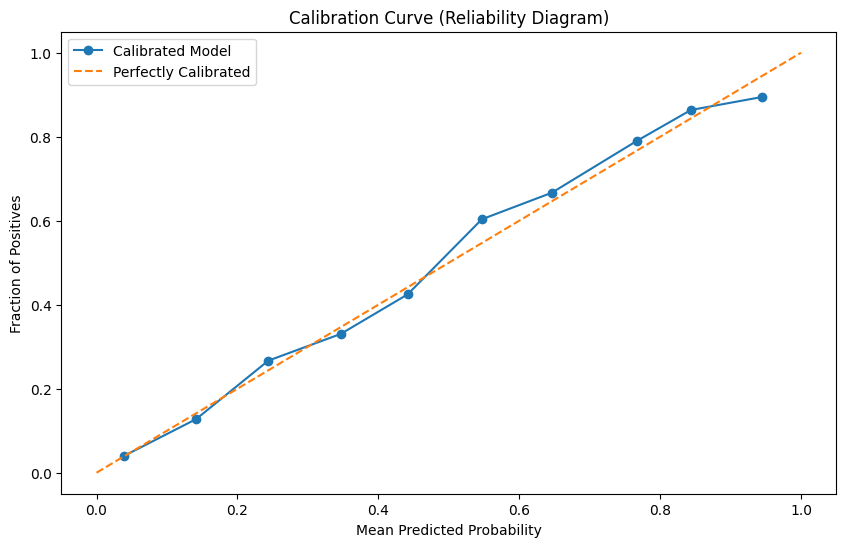

In [123]:
def plot_calibrated_model(calibrated_model, validation_loader, device):
    model.eval()
    logits_list = []
    labels_list = []

    # Collect logits and labels from the validation set
    with torch.no_grad():
        for x1, x2, labels in validation_loader:
            x1, x2, labels = x1.to(device), x2.to(device), labels.to(device)
            outputs, _ = model(x1, x2)
            logits_list.append(outputs.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    logits = np.concatenate(logits_list)
    labels = np.concatenate(labels_list)

    # Use the calibrated model to get probabilities
    calibrated_probs = calibrated_model.predict_proba(logits)[:, 1]

    # Calculate the calibration curve
    prob_true, prob_pred = calibration_curve(labels, calibrated_probs, n_bins=10)

    # Plot the calibration curve
    plt.figure(figsize=(10, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibrated Model')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve (Reliability Diagram)')
    plt.legend()
    plt.show()

# Call the function to plot the calibrated model
plot_calibrated_model(calibrated_model, valid_dl, device)

In [116]:
# Assuming you have your validation data prepared
X_val_cat = X_val.loc[:, emb_cols].values.astype(np.int64)
X_val_cont = X_val.drop(columns=emb_cols).values.astype(np.float32)
y_val = y_val.values.astype(np.float32)

# Convert to tensors
X_val_cat_tensor = torch.tensor(X_val_cat, dtype=torch.long).to(device)
X_val_cont_tensor = torch.tensor(X_val_cont, dtype=torch.float32).to(device)

# Get logits from the model
model.eval()
with torch.no_grad():
    logits, _ = model(X_val_cat_tensor, X_val_cont_tensor)

# Convert logits to numpy array
logits_np = logits.cpu().numpy()

# Use the calibrated model to get probabilities
calibrated_probs = calibrated_model.predict_proba(logits_np)[:, 1]  # Get the probability of the positive class

In [122]:
# Assuming calibrated_probs and y_val are numpy arrays
# Convert them to a DataFrame
results_df = pd.DataFrame({
    'calibrated_probs': calibrated_probs,
    'y_val': y_val
})

# Calculate the difference and store it in a new column
results_df['difference'] = abs(results_df['calibrated_probs'] - results_df['y_val'])

# Display the DataFrame
print(results_df.head())

   calibrated_probs  y_val  difference
0          0.057994    0.0    0.057994
1          0.224228    0.0    0.224228
2          0.796653    1.0    0.203347
3          0.226090    1.0    0.773910
4          0.093949    0.0    0.093949


Interestingly the model appears to be well callibrated out of the box without any additional scalling. The calibrated model appears to be slightly more accurate than the uncalibrated model, but only by a small margin.